In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
import os 
import zipfile

In [2]:
## Unzip data if needed 



# Define paths for each zip file
zip_files = {
    "dataset": "FullDataset/bondugula_JDO_20230125_SLIM.csv.zip",
    "notebook1": "FullDataset/full-data-nb.ipynb.zip",
    "notebook2": "FullDataset/full-data-practice-041223.ipynb.zip",
    "notebook3": "FullDataset/full-data-practice-061023.ipynb.zip",
    "notebook4": "FullDataset/full-data-practice-20230225.ipynb.zip",
    "unknown_csv": "FullDataset/s8-acetyl+sirt-output.csv.zip"
}

# Function to unzip files
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Directory to extract all files
extract_dir = "Unzipped_Files"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip each file
for name, path in zip_files.items():
    output_folder = os.path.join(extract_dir, name)  # Folder based on each file's label
    os.makedirs(output_folder, exist_ok=True)
    unzip_file(path, output_folder)

Extracted FullDataset/bondugula_JDO_20230125_SLIM.csv.zip to Unzipped_Files\dataset
Extracted FullDataset/full-data-nb.ipynb.zip to Unzipped_Files\notebook1
Extracted FullDataset/full-data-practice-041223.ipynb.zip to Unzipped_Files\notebook2
Extracted FullDataset/full-data-practice-061023.ipynb.zip to Unzipped_Files\notebook3
Extracted FullDataset/full-data-practice-20230225.ipynb.zip to Unzipped_Files\notebook4
Extracted FullDataset/s8-acetyl+sirt-output.csv.zip to Unzipped_Files\unknown_csv


# View dataset

This is from the supplementary material document in Jonathans paper: 

To obtain the possible secondary structure input values required to calculate Vkabat, the FASTA sequence was input to the fifteen following algorithms: GOR1, GOR3, DPM, PREDATOR, HNNC, SOPM, MLRC, DSC, JPRED, PHD, PROF, SSPRO, YASPIN, JNET, and PSIPRED [3,10]. From this output, we calculated Vkabat for each residue.

This implies that we should not use those columns 

In [4]:
# Define path to data and define it
file_path = "Unzipped_Files/dataset/bondugula_JDO_20230125_SLIM.csv"
data = pd.read_csv(file_path, index_col=0)

# View data
print(data.columns)
data.head(5)

Index(['Residue', 'E6', 'E20', 'Protein', 'No.', 'Res', 'isUnstruct', 'E6.1',
       'E20.1', 'E22', 'Vkbat', 'chou_fasman', 'sspro_5', 'gor4', 'dsc',
       'jnet', 'psipred', '# homologues', 'HAS_H', 'HAS_S', 'HAS_O', 'HAS_U',
       'ProteinID'],
      dtype='object')


,Residue,E6,E20,Protein,No.,Res,isUnstruct,E6.1,E20.1,E22,...,gor4,dsc,jnet,psipred,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,ProteinID
0,D,0.926212,0.926212,2BDE,1,D,0.954544,NaN,NaN,NaN,...,Other,Other,Other,Other,6,0,0,0,1,2BDE_0
1,T,1.307625,2.024379,2BDE,2,T,0.805483,NaN,NaN,NaN,...,Other,Other,Other,Other,6,0,0,0,1,2BDE_0
2,H,1.321518,1.668090,2BDE,3,H,0.654102,NaN,NaN,NaN,...,Other,Other,Other,Helix,6,0,0,0,1,2BDE_0
3,K,0.528085,0.845275,2BDE,4,K,0.501600,NaN,NaN,NaN,...,Other,Other,Other,Helix,6,0,0,1,1,2BDE_0
4,V,0.000000,0.583619,2BDE,5,V,0.280561,NaN,NaN,NaN,...,Sheet,Sheet,Sheet,Helix,6,0,1,0,1,2BDE_0


We know the descriptors are:
* E6 (?)
* E20 (?)
* isUnstruct (Disorder Propensity)

The target that we need to define is the switch. This occurs when HAS_H, HAS_S, HAS_O, HAS_U added together is greater than 1. We need to make this column

In [5]:
# Create a copy dataframe of region of interest 
switch_det = data.iloc[:, -5:-1]

# Define new column that detects the switch occuring 
switch_det['switch'] = (switch_det.sum(axis=1) > 1).astype(int) # Create binar column, True = 1 and False = 0

# Print values
switch_det.head(3)

,HAS_H,HAS_S,HAS_O,HAS_U,switch
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0


In [6]:
print(switch_det['switch'].value_counts())

switch
0    914237
1    179049
Name: count, dtype: int64


In [7]:
# Add our switch column to the main one 
data2 = data.copy()

data2 = pd.concat([data2, switch_det['switch']], axis=1)
data2.head(5)

,Residue,E6,E20,Protein,No.,Res,isUnstruct,E6.1,E20.1,E22,...,dsc,jnet,psipred,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,ProteinID,switch
0,D,0.926212,0.926212,2BDE,1,D,0.954544,NaN,NaN,NaN,...,Other,Other,Other,6,0,0,0,1,2BDE_0,0
1,T,1.307625,2.024379,2BDE,2,T,0.805483,NaN,NaN,NaN,...,Other,Other,Other,6,0,0,0,1,2BDE_0,0
2,H,1.321518,1.668090,2BDE,3,H,0.654102,NaN,NaN,NaN,...,Other,Other,Helix,6,0,0,0,1,2BDE_0,0
3,K,0.528085,0.845275,2BDE,4,K,0.501600,NaN,NaN,NaN,...,Other,Other,Helix,6,0,0,1,1,2BDE_0,1
4,V,0.000000,0.583619,2BDE,5,V,0.280561,NaN,NaN,NaN,...,Sheet,Sheet,Helix,6,0,1,0,1,2BDE_0,1


# Data Pre-Processing

## Lets check our columns have valid data

In [8]:
# See if there is any missing values 
print("Missing data:")
print(data2.isnull().sum())

Missing data:
Residue               0
E6                 3710
E20                3710
Protein               0
No.                   0
Res                   0
isUnstruct            0
E6.1            1093286
E20.1           1093286
E22             1093286
Vkbat                 0
chou_fasman           0
sspro_5               0
gor4                  0
dsc                   0
jnet                  0
psipred               0
# homologues          0
HAS_H                 0
HAS_S                 0
HAS_O                 0
HAS_U                 0
ProteinID             0
switch                0
dtype: int64


Based off Jonathan's notebook E6.1, E20.1, E22 are not used at all. We can drop these. As far as the 3710 entries missing we can drop those rows as well.

In [9]:
# Drop those missing data values
data2.drop(columns=['E6.1', 'E20.1', 'E22'], inplace=True)
data2.dropna(inplace=True)

# Normalize data 

In [10]:
# View data descriptive stats
data2.describe()

,E6,E20,No.,isUnstruct,Vkbat,# homologues,HAS_H,HAS_S,HAS_O,HAS_U,switch
count,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06,1.089576e+06
mean,4.613143e-01,7.981048e-01,1.800823e+02,2.363689e-01,2.752236e+00,1.674654e+01,4.094391e-01,2.390545e-01,2.641165e-01,2.677060e-01,1.638463e-01
std,6.268500e-01,9.191382e-01,1.657662e+02,2.300717e-01,1.629132e+00,3.857491e+01,4.917306e-01,4.265063e-01,4.408618e-01,4.427637e-01,3.701362e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,5.706888e-04,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.083201e-02,6.200000e+01,6.579392e-02,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.079314e-02,3.989436e-01,1.340000e+02,1.516327e-01,2.400000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.515738e-01,1.383933e+00,2.480000e+02,3.318337e-01,3.000000e+00,1.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
max,2.581541e+00,4.207811e+00,1.505000e+03,1.000000e+00,9.000000e+00,1.174000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
data2.value_counts()

Residue  E6        E20       Protein  No.  Res  isUnstruct  Vkbat  chou_fasman  sspro_5  gor4   dsc    jnet   psipred  # homologues  HAS_H  HAS_S  HAS_O  HAS_U  ProteinID  switch
A        0.000000  0.000000  12AS     51   A    0.420204    2.4    Helix        Sheet    Helix  Helix  Helix  Helix    4             0      0      0      1      12AS_0     0         1
P        0.812784  0.867610  2G5R     66   P    0.272055    2.4    Helix        Other    Other  Other  Other  Other    6             0      0      1      1      2G5R_0     1         1
         0.811526  0.811526  1L4D     49   P    0.469069    3.0    Helix        Other    Helix  Other  Other  Other    2             0      1      0      1      1L4D_0     1         1
         0.811556  0.966644  2JE6     156  P    0.062806    6.0    Sheet        Helix    Other  Other  Other  Sheet    8             1      0      1      0      2JE6_2     1         1
         0.811848  0.927833  2GUM     247  P    0.076498    2.4    Sheet        Other

As expected all different scales. We need to scale the data so its on a normal distribution. We also need to One Hot encode all the categorical data

In [12]:
# Initialize Standard Scaler 
scaler = StandardScaler()

# Seperate features from target 
data_quantitative = data2[["E6", 'E20', "isUnstruct", "Vkbat"]]

# Fit and transform data 
standardized_data = scaler.fit_transform(data_quantitative)

# Convert to dataframe
standardized_df = pd.DataFrame(standardized_data, columns=data_quantitative.columns, index=data2.index)
standardized_df.head(3)

,E6,E20,isUnstruct,Vkbat
0,0.741642,0.139378,3.121528,-1.075564
1,1.350102,1.334157,2.473639,-0.216211
2,1.372264,0.946523,1.815667,1.072820


## One Hot Encode categorical data (Qualitative features)

The categorical data that Jonathan used were 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'

In [13]:
# Initialize One Hot Encoder
ohe = OneHotEncoder()

# Encode categorical data
ohe_features_array = ohe.fit_transform(data2[['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred']]).toarray()

# View result
print(ohe_features_array)
print(len(ohe_features_array))

feature_labels = ohe.categories_
print(feature_labels)

[[0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]]
1089576
[array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object)]


In [14]:
feature_labels = ohe.get_feature_names_out(['chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'])
print(feature_labels)

['chou_fasman_Helix' 'chou_fasman_Other' 'chou_fasman_Sheet'
 'sspro_5_Helix' 'sspro_5_Other' 'sspro_5_Sheet' 'gor4_Helix' 'gor4_Other'
 'gor4_Sheet' 'dsc_Helix' 'dsc_Other' 'dsc_Sheet' 'jnet_Helix'
 'jnet_Other' 'jnet_Sheet' 'psipred_Helix' 'psipred_Other' 'psipred_Sheet']


In [15]:
ohe_df = pd.DataFrame(ohe_features_array, columns=feature_labels, index=data2.index)
ohe_df.head(3)

,chou_fasman_Helix,chou_fasman_Other,chou_fasman_Sheet,sspro_5_Helix,sspro_5_Other,sspro_5_Sheet,gor4_Helix,gor4_Other,gor4_Sheet,dsc_Helix,dsc_Other,dsc_Sheet,jnet_Helix,jnet_Other,jnet_Sheet,psipred_Helix,psipred_Other,psipred_Sheet
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Convert Oridanal to Numeric and scale it

In [16]:
# Initialize Ordinal encoder
ord = OrdinalEncoder()

# Encode Ordinal data which is Residue
ord_features_array = ord.fit_transform(data2[["Residue", 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred']])

# View result
print(ord_features_array)
print(len(ord_features_array))

feature_labels_ord = ord.categories_
print(feature_labels_ord)

[[ 2.  1.  1. ...  1.  1.  1.]
 [16.  2.  1. ...  1.  1.  1.]
 [ 6.  2.  1. ...  1.  1.  0.]
 ...
 [12.  1.  1. ...  1.  1.  1.]
 [ 0.  1.  1. ...  1.  1.  1.]
 [ 0.  1.  1. ...  1.  1.  1.]]
1089576
[array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object), array(['Helix', 'Other', 'Sheet'], dtype=object)]


In [17]:
feature_labels_ord = ord.get_feature_names_out(["Residue", 'chou_fasman', 'sspro_5', 'gor4', 'dsc', 'jnet', 'psipred'])
print(feature_labels_ord)

['Residue' 'chou_fasman' 'sspro_5' 'gor4' 'dsc' 'jnet' 'psipred']


In [19]:
ord_df = pd.DataFrame(ord_features_array, columns=feature_labels_ord, index=data2.index)
ord_df.head(3)

,Residue,chou_fasman,sspro_5,gor4,dsc,jnet,psipred
0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
1,16.0,2.0,1.0,1.0,1.0,1.0,1.0
2,6.0,2.0,1.0,1.0,1.0,1.0,0.0


In [20]:
### Another oridinal column is the # of Homologues. Its already in numeric format we just need to scale it.
ord_data = pd.concat([ord_df, data2["# homologues"]], axis=1)
print(ord_data.isnull().sum())

# Scale ordinal data 
ord_standard = scaler.fit_transform(ord_data)

# Convert to dataframe
standardized_ord_df = pd.DataFrame(ord_standard, columns=ord_data.columns, index=data2.index)
standardized_ord_df.head(3)


Residue         0
chou_fasman     0
sspro_5         0
gor4            0
dsc             0
jnet            0
psipred         0
# homologues    0
dtype: int64


,Residue,chou_fasman,sspro_5,gor4,dsc,jnet,psipred,# homologues
0,-1.216395,0.087723,0.243174,0.244387,0.136027,0.251425,0.248920,-0.278589
1,1.157032,1.232389,0.243174,0.244387,0.136027,0.251425,0.248920,-0.278589
2,-0.538273,1.232389,0.243174,0.244387,0.136027,0.251425,-1.075531,-0.278589


### Merge all preprocessing and drop columns we no longer need for Modeling

In [34]:
# Merge all the preprocessed data and target 
merged_df = pd.concat([standardized_df, ohe_df, data2['switch']], axis=1)
merged_df.head(3)

,E6,E20,isUnstruct,Vkbat,chou_fasman_Helix,chou_fasman_Other,chou_fasman_Sheet,sspro_5_Helix,sspro_5_Other,sspro_5_Sheet,...,dsc_Helix,dsc_Other,dsc_Sheet,jnet_Helix,jnet_Other,jnet_Sheet,psipred_Helix,psipred_Other,psipred_Sheet,switch
0,0.741642,0.139378,3.121528,-1.075564,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,1.350102,1.334157,2.473639,-0.216211,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,1.372264,0.946523,1.815667,1.072820,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0


In [35]:
print(merged_df.columns)

Index(['E6', 'E20', 'isUnstruct', 'Vkbat', 'chou_fasman_Helix',
       'chou_fasman_Other', 'chou_fasman_Sheet', 'sspro_5_Helix',
       'sspro_5_Other', 'sspro_5_Sheet', 'gor4_Helix', 'gor4_Other',
       'gor4_Sheet', 'dsc_Helix', 'dsc_Other', 'dsc_Sheet', 'jnet_Helix',
       'jnet_Other', 'jnet_Sheet', 'psipred_Helix', 'psipred_Other',
       'psipred_Sheet', 'switch'],
      dtype='object')


# Modeling Quantitative with Qualitative Descriptors

In [36]:
# Define features and target
X = merged_df.iloc[:, :-1]
y = merged_df.iloc[:, -1]

# Add intercept for modeling purposes
X = sm.add_constant(X)

# Create Train test split based on features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)

## Logit Classifier

In [37]:
# Create Logistic model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Review summary of training
print(result.summary())
print()

         Current function value: 0.438838
         Iterations: 35


c:\Users\delga\anaconda3\envs\orlucent_machinelearning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:               871660
Model:                          Logit   Df Residuals:                   871641
Method:                           MLE   Df Model:                           18
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                 0.01586
Time:                        18:31:08   Log-Likelihood:            -3.8252e+05
converged:                      False   LL-Null:                   -3.8868e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5740   1.02e+04  -5.63e-05      1.000      -2e+04       2e+04
E6                    0.0462      0.007      6.336      0.000       0.032       0.060
E20                  -0.

In [ ]:
# Predict probabilities for the test data and train data
y_pred_prob_test = result.predict(X_test)
y_pred_prob_train = result.predict(X_train)

# Convert probabilities to binary predictions (0 or 1)
y_pred_test = (y_pred_prob_test > 0.5).astype(int)  # Using 0.5 as the threshold for now
y_pred_train = (y_pred_prob_train > 0.5).astype(int)

# Compare predicted values to actual values
acc_test = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

print(f"Accuracy Train: {acc_train:.4f}")
print(f"Accuracy Test: {acc_test:.4f}")

Accuracy Train: 0.8362
Accuracy Test: 0.8359


In [44]:
from sklearn.metrics import confusion_matrix
# Create sensitivity and specificity calc
def sens_spec_calc(y_pred, y_true):
    # Create confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calc Sens and Spec
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    print("Sensitivity:", sens)
    print("Specificity:", spec)

print("Training:")
sens_spec_calc(y_pred=y_pred_train, y_true=y_train)
print("Testing:")
sens_spec_calc(y_pred=y_pred_test, y_true=y_test)

Training:
Sensitivity: 0.0
Specificity: 1.0
Testing:
Sensitivity: 0.0
Specificity: 1.0


We can see how the model is not overfitting the data at all. The train and testing sets are nearly identical performances. Let see if an OLS model can do better.

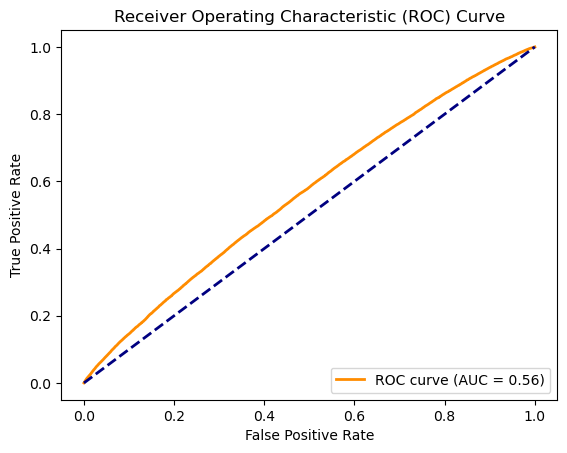

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

# Make ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_test)
roc_auc = roc_auc_score(y_test, y_pred_prob_test)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## OLS Model

In [33]:
# Create OLS model 
ols = sm.OLS(y_train, X_train)

# Obtain result
ols_result = ols.fit()

# Print summary 
print(ols_result.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                 switch   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1630.
Date:                Tue, 12 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:27:47   Log-Likelihood:            -3.6714e+05
No. Observations:              871660   AIC:                         7.343e+05
Df Residuals:                  871655   BIC:                         7.344e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1638      0.000    414.799      0.0

# Explore Ensemble Models